# Problem Statement

The high readmission level of hospital patients after they are discharged from the hospital is a significant concern for the health care system. The estimated cost of hospital readmissions is about $17.4 billion annually. While some readmissions are due to normal medical complications, such high readmission rates are generally viewed as symptomatic of deeper problems in the health care system, namely potential quality problems within hospitals, lack of coordination in follow-up care after discharge, and misaligned financial incentives to discharge patients early (see Reference: https://www.cms.gov/Medicare/Medicare-Fee-forServicePayment/AcuteInpatientPPS/Readmissions-Reduction-Program ).

To address the problem, the 2010 Affordable Care Act established a hospital readmissions reduction program (HRRP). The program created financial incentives for hospitals to reduce readmissions by linking Medicare reimbursements to a hospital’s risk-adjusted readmission rate. 
The initial phase of the HRRP, focused on three conditions: 
- Acute myocardial infarction (AMI), 
- heart failure (HF), 
- Pneumonia

Hospitals that had a three-year rolling readmission rate for these conditions that exceeded their risk adjusted target were to be penalized a portion of their Medicare reimbursements. 
For 2012, penalties could be as much 1\% of the total reimbursements a hospital received for the three target conditions. 
In the first year of the program, 2225 hospitals were subject to reduced payment penalties, with  penalties totaling $225 million nationwide. The maximum penalties were set to increase to 3% of reimbursements by 2014.

Approximately 20% of healthcare systems provider were insurance reimbursements from Medicare for the three conditions (acute myocardial infarction, heart failure, and pneumonia) covered by the HRRP.
 A significant portion of the healthcare systems provider’s revenue could be at risk due to HRRP penalties.
The concern over the impact of HRRP penalties over the coming years, healthcare systems providers started to look into the hospitals readmission rate within 30 days to come up them with a good strategy. 

Data on all admissions over the last three years for patient is provided with data dictionary. What insights you could glean from the data and what recommendations you could make. 

## Data Dictionary

- age: Age at time of admission
- female: 1 = Female, 0=Male
- flu_season: Flu Season (1 = Yes). Admission starting December through March
- ed_admit: Admitted through the ED (1 = Yes).
- severity score: Generic physiologic severity of illness score based on lab tests and vital signs
- comorbidity score: Severity score based on patients’ pre-existing diagnoses.
- readmit30: Indicator for hospital readmission within 30 days. 1 if readmitted, 0 otherwise.

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_score,recall_score,precision_recall_curve,plot_precision_recall_curve,f1_score,accuracy_score,roc_auc_score


# Data Set

In [2]:
df=pd.read_csv('readmission.csv')
df.head()

,age,female,flu_season,ed_admit,severity score,comorbidity score,readmit30
0,100,1,1,1,38,112,0
1,83,1,0,1,8,109,1
2,74,0,1,0,1,80,0
3,66,1,1,1,25,4,0
4,68,1,1,1,25,32,0


# Data Cleaning

In [3]:
# Check to see if there are any incorrect values, for example, numbers other 
# than 1 or 0 for a dummy variable
df.describe()

,age,female,flu_season,ed_admit,severity score,comorbidity score,readmit30
count,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000
mean,76.847330,0.469192,0.408033,0.809220,22.353263,94.735509,0.227750
std,7.904949,0.499107,0.491525,0.392961,18.005320,57.145155,0.419428
min,65.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,70.000000,0.000000,0.000000,1.000000,8.000000,51.000000,0.000000
50%,76.000000,0.000000,0.000000,1.000000,19.000000,86.000000,0.000000
75%,82.000000,1.000000,1.000000,1.000000,32.000000,131.000000,0.000000
max,105.000000,1.000000,1.000000,1.000000,112.000000,322.000000,1.000000


In [4]:
# Check to see if there are any null values 
df.isnull().values.any()

False

In [5]:
# Since the units of age, severity score and comorbidity score are
# difficult to interpret, we will need to normalize the values
# First we will create a function to normalize the values in the dataframe

def normalize(raw_data):
    """ Returns the dataframe after normalizing its values. Prints the first five results
        after standardizing the values. 
        
        Parameters:
            raw_data(DataFrame): a dataframe
            
        Returns:
            X (Dataframe): data with normalized values 
    """
    X = raw_data
    X = (X - X.mean()) / X.std()
    print(X.head(5))
    return X

In [6]:
# Now we will normalize the values for age, severity score, and comorbidity score

norm_df = normalize(df[['age', 'severity score', 'comorbidity score']])

        age  severity score  comorbidity score
0  2.928883        0.869006           0.302116
1  0.778331       -0.797168           0.249619
2 -0.360196       -1.185942          -0.257861
3 -1.372220        0.146997          -1.587808
4 -1.119214        0.146997          -1.097827


In [7]:
# Add the other columns of data to the normalized dataframe
clean_df = pd.concat([df[['female', 
                           'flu_season', 
                           'ed_admit', 
                           'readmit30']], norm_df], axis=1)

# Show the new data frame with the clean data 
clean_df

,female,flu_season,ed_admit,readmit30,age,severity score,comorbidity score
0,1,1,1,0,2.928883,0.869006,0.302116
1,1,0,1,1,0.778331,-0.797168,0.249619
2,0,1,0,0,-0.360196,-1.185942,-0.257861
3,1,1,1,0,-1.372220,0.146997,-1.587808
4,1,1,1,0,-1.119214,0.146997,-1.097827
...,...,...,...,...,...,...,...
4377,1,0,1,0,1.410847,0.646850,-0.012871
4378,0,0,1,0,2.675877,1.591015,0.722100
4379,1,0,1,0,0.904834,-0.686090,-1.097827
4380,1,1,1,0,-1.245717,-0.686090,-0.380356


In [8]:
# Change the remaining variables into str format to
# convert them into categorical/factor variables 

# create a list of columns to convert 
cols = ['female', 'flu_season', 'ed_admit']

# use a for loop to loop through the columns and convert
for col in cols:
    clean_df[col]=clean_df[col].astype('str')

In [9]:
# rename columns severity score and comorbidity score to
# remove the spaces
clean_df = clean_df.rename(columns={'severity score': 'severity_score', 
                                    'comorbidity score': 'comorbidity_score'})

In [10]:
clean_df.dtypes

female                object
flu_season            object
ed_admit              object
readmit30              int64
age                  float64
severity_score       float64
comorbidity_score    float64
dtype: object

# Exploring Data 

 ## What percentage of  patients readmitted in 30 days?

In [11]:
print('Number of patients who were readmitted in 30 days:','\n', clean_df['readmit30'].value_counts(normalize=False),'\n')

print('Percentage of patients who were readmitted in 30 days:','\n', clean_df['readmit30'].value_counts(normalize=True))

Number of patients who were readmitted in 30 days: 
 0    3384
1     998
Name: readmit30, dtype: int64 

Percentage of patients who were readmitted in 30 days: 
 0    0.77225
1    0.22775
Name: readmit30, dtype: float64


Given that a readmission to the hospital is denoted by a 1 for the `readmit30` variable, we know that **about 22.78% of patients were readmitted in 30 days.**

<AxesSubplot:xlabel='readmit30', ylabel='Counts'>

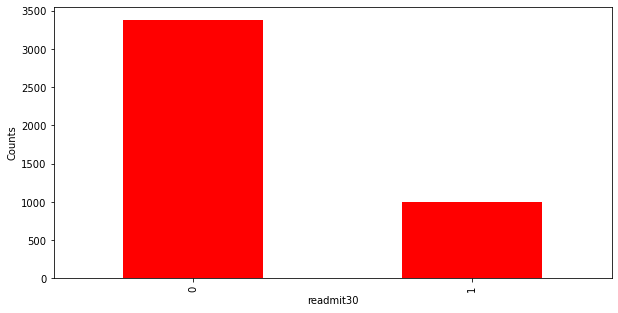

In [12]:
# plot the number of patients who were readmitted in 30 days 
fig, ax = plt.subplots(figsize=(10,5))
clean_df['readmit30'].value_counts().plot(ax=ax, 
                                    kind='bar', 
                                    xlabel='readmit30', 
                                    ylabel='Counts',
                                    color='red')
# plt.savefig('now_show.png')

## Is there dependency between readmission in 30 days and Flu season at 95% confidence level? 

<AxesSubplot:xlabel='readmit30', ylabel='count'>

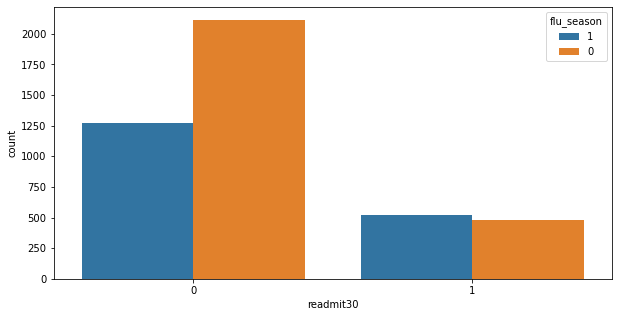

In [13]:
# First we can plot 
fig, ax = plt.subplots(figsize=(10,5))

sns.countplot(x='readmit30',hue='flu_season',data=clean_df)
# plt.savefig('now_show_sms.png')


In [14]:
data=pd.crosstab(index=clean_df["readmit30"], 
                            columns=clean_df["flu_season"],
                             margins=True,
                             normalize=False).round(2)
data

flu_season,0,1,All
readmit30,,,
0,2113,1271,3384
1,481,517,998
All,2594,1788,4382


### Chi-square Test at the 95% confidence level 

In [15]:
# defining the table using the cross_data
stat, p, dof, expected = chi2_contingency(data)

# since we have a 95% confidence level, our alpha will
# be: 1 - 0.95 = 0.05
alpha = 0.05

print("Chi-square test value is " + str(stat.round(2)), " and ","the p value is " + str(p))
if p <= alpha:
    print('Reject H0: Patient readmission in 30 days depends on flu season')
else:
    print('Fail to reject H0: Patient readmission in 30 days does not depends on flu season')

Chi-square test value is 64.74  and  the p value is 2.9153013948676207e-13
Reject H0: Patient readmission in 30 days depends on flu season


# Logistic Regression

## Split to Training and Testing Set

In [16]:
# Select features to be used for training model
features = ['age','female',
            'flu_season',
            'ed_admit',
            'severity_score',
            'comorbidity_score']

X=clean_df[features].values
y=clean_df['readmit30'].values

# split into 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1,stratify=y)
  
# describes info about train and test set
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)


Number transactions X_train dataset:  (3067, 6)
Number transactions y_train dataset:  (3067,)
Number transactions X_test dataset:  (1315, 6)
Number transactions y_test dataset:  (1315,)


## Training Model 

In [17]:
# create the training dataframe and convert the readmit30 into type int
df_train=pd.DataFrame(np.column_stack((X_train, y_train)),columns = features+['readmit30'])
df_train['readmit30']=df_train['readmit30'].astype(int)


# create the testing dataframe 
df_test=pd.DataFrame(np.column_stack((X_test, y_test)),columns = features+['readmit30'])
df_test['readmit30']=df_test['readmit30'].astype(int)

# Convert the normalized values into type float 
colmns=['age', 'severity_score', 'comorbidity_score']
for col in colmns:
        df_train[col]=df_train[col].astype('float')
        df_test[col]=df_test[col].astype('float')


In [18]:
# Create the logistic regression using GLM
formula = 'readmit30 ~ age+female+flu_season+ed_admit+severity_score+comorbidity_score'

model = smf.glm(formula = formula, data=df_train, family=sm.families.Binomial(link= sm.families.links.logit()))

result_GLM = model.fit()
print(result_GLM.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              readmit30   No. Observations:                 3067
Model:                            GLM   Df Residuals:                     3060
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1315.6
Date:                Sun, 16 Oct 2022   Deviance:                       2631.3
Time:                        18:10:38   Pearson chi2:                 2.97e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.8060      0.14

## Analysis 

4. Comment on significance of predictors
5. Comment on main driver(s)
6. Interpret the effect of sex and comorbidity score on the 30 days readmition  

#### Significant Drivers of Hospital Re-admission 

From this model, we can see that:
- The significant predictors include **flu season, severity score and comorbidity score** as they have p-values that are equal to 0
    - This indicates that they are **significant at the 1, 5, and 10% levels.**
    - Other variables such as **sex, ed_admit and age** are not significant since the p-values are greater than 0.1, meaning they are not significant even at the 10% level
- From the coefficients, we can say that the main driver of hospital readmission in 30 days is **the comorbidity score of the patient**, followed by **the flu season and the patient's severity score**

#### Effect of comorbidity score on 30 days Re-admission 

- By definition, comorbidity indicates that a **patient currently has two or more diseases or medical conditions**
    - Since the comorbidity variable indicates the severity score of a patient based on their previous diagnosis, we can associate a **higher comorbidity scores with patients that have more severe pre-existing illnesses**
- According to this model, patients who have a higher comorbidity score are **more likely to be readmitted to the hospital within 30 days** than those who have a lower score

#### Effect of sex on 30 days Re-admission

- From the coefficient on sex we can see that patients who are female have a **10.26%(exp(0.0986)=1.1036) more odds (relative risk) of being re-admitted** to the hospital within 30 days **compared to those who are male.**

## Performance Evaluation Using Test Set 

### Cutoff value at .5

The test set below sets the cut-off value to 0.5 for the `readmit30` variable. This indicates that **if a prediction value is greater than or equal to 0.5, it will categorize the prediction as 1,** which in this case, indicates that the patient will be readmitted within 30 days. On the other hand, **if the prediction value is less than 0.5, then the model will categorize it as a 0**, indicating that they will not be re-admitted within 30 days. 

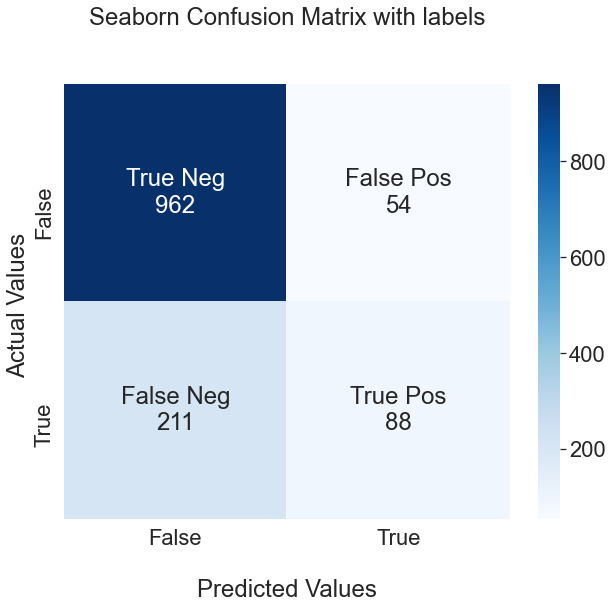

Precision: 0.62
Recall: 0.29
Accuracy: 0.8
F1-score: : 0.4


In [19]:
# We can use the Test Set to evaluate 
# the performance of the logistic model. 

# calculating precision and recall while setting the cutoff 
# value to 0.5
predictions = result_GLM.predict(df_test)
predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]

# Plot confusion matrix
cf_matrix=confusion_matrix(df_test["readmit30"],  predictions_nominal)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.set(rc = {'figure.figsize':(10,8)})
sns.set(font_scale = 2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()


precision = precision_score(df_test["readmit30"],  predictions_nominal)
recall = recall_score(df_test["readmit30"],  predictions_nominal)
accuracy= accuracy_score(df_test["readmit30"],  predictions_nominal)
F1_score= f1_score(df_test["readmit30"],  predictions_nominal)


print('Precision: {}'.format(round(precision,2)))
print('Recall: {}'.format(round(recall,2)))
print('Accuracy: {}'.format(round(accuracy,2)))
print('F1-score: : {}'.format(round(F1_score,2)))

The confusion matrix above presents the performance results of the model using the predicted and actual values. We can see that:
- There are **962 patients who correctly labeled as negative** for the `readmit30` variable 
- There are **211 patients who were incorrectly labeled as negative** for the `readmit30` variable when they are actually supposed to labeled as positive
- There are **54 patients who were incorrectly labeled as positive** for the `readmit30`variable when they are supposed to be labeled as negative 
- There are **88 patients who were correctly labeled as positive** for the `readmit30` variable 

From the matrix above, we can also calculate the **precision, recall, accuracy and F1-score.**
- The **precision** of the model is the percent of true positives out of all predicted positives: **TP/(TP + FP)**
- The **recall** of the model is the percent of true positives out of all observed positive values: **TP/(TP + FN)**
- The **accuracy** of the model is the percent of correctly predicted values over all predicted values: **TN + TP / (TN + TP + FN + FP)**
- The **F1-score** of the model tells us the precision and recall of the model: **2 * (Precision * Recall) / (Precision + Recall)**, where an F1-score of 1 indicates **perfect precision and recall**

Based on the calculated model performance values, we can see that:
- 62% of positively predicted patients were actually positive (Precision)
- 29% of the patients who were recorded as positive for `readmit30` were correctly predicted as positive according to our model (Recall)
- 80% of the models predictions were correct (Accuracy)
- Our F1-score is 0.4 which is not ideal since a higher F1-score indicates a better model with higher precision and recall. 

## ROC/AUC 

Area under the ROC curve : 0.755909


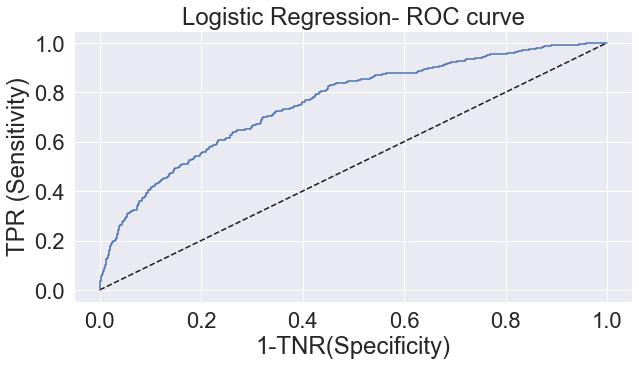

In [20]:
# roc_curve will return false positive rate, true positive rate for given threshold

fpr, tpr, thresholds =roc_curve(df_test["readmit30"], predictions)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('1-TNR(Specificity)')
plt.ylabel('TPR (Sensitivity)')
plt.title('Logistic Regression- ROC curve')
plt.show()

The plot above shows the ROC curve for our logistic model. The dotted line shows a model with an Area Under the Curve (AUC) of 0.5, indicating that it has **no seperating capacity**. A perfect model will have an AUC of 1, meaning that it is able to perfectly distinguish between patients who will and will not be readmitted in 30 days.

The blue curve shows the ROC for our logistic model. We can see that it is much better than the AUC of 0.5, but still not close to a perfect model of 1 as the **AUC = 0.755909.**

## Finding the Optimal Threshold 

          fpr       tpr     1-fpr  difference  thresholds
0    0.000000  0.000000  1.000000   -1.000000    1.943216
1    0.000000  0.003344  1.000000   -0.996656    0.943216
2    0.000000  0.016722  1.000000   -0.983278    0.901809
3    0.000984  0.016722  0.999016   -0.982293    0.895601
4    0.000984  0.036789  0.999016   -0.962226    0.850258
..        ...       ...       ...         ...         ...
416  0.943898  0.993311  0.056102    0.937209    0.037994
417  0.943898  0.996656  0.056102    0.940553    0.037738
418  0.959646  0.996656  0.040354    0.956301    0.033208
419  0.959646  1.000000  0.040354    0.959646    0.033077
420  1.000000  1.000000  0.000000    1.000000    0.016812

[421 rows x 5 columns]
          fpr       tpr     1-fpr  difference  thresholds
244  0.317913  0.685619  0.682087    0.003532    0.211935


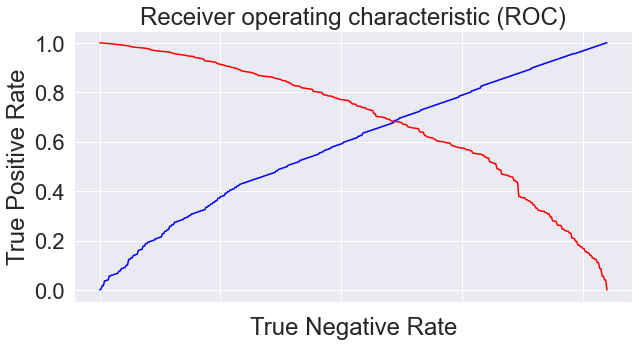

In [21]:
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),
                    'tpr' : pd.Series(tpr, index = i), 
                    '1-fpr' : pd.Series(1-fpr, index = i), 
                    'difference' : pd.Series(tpr - (1-fpr), index = i), 
                    'thresholds' : pd.Series(thresholds, index = i)})
print(roc)
##
print(roc.iloc[(roc.difference-0).abs().argsort()[:1]])

# Plot tpr vs 1-fpr
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(roc['tpr'],color='blue')
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('True Negative Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
ax.set_xticklabels([])
plt.savefig('ROC_optimal.png')


From the chart above, we can see that our **optimal threshold is at 0.211935.**

## Setting 0.21 as Optimal Threshold 

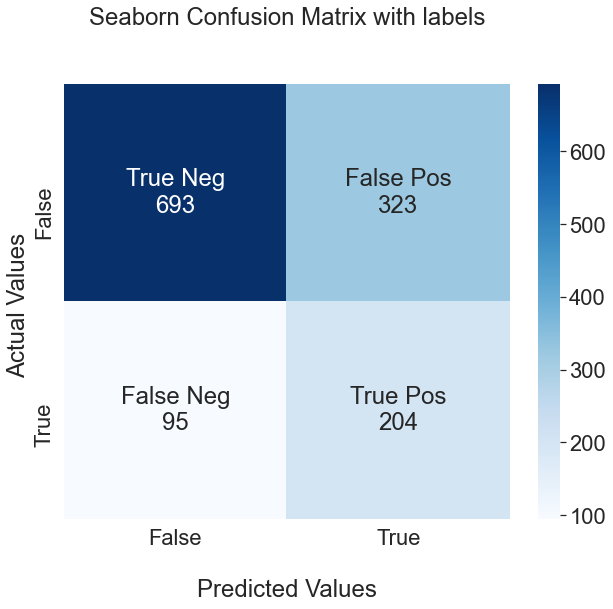

Precision: 0.39
Recall: 0.68
Accuracy: 0.68
F1-score: : 0.49


In [22]:
# Now we can use our optimal threshold to 
# recalculate the precision and reall
predictions = result_GLM.predict(df_test)
predictions_nominal = [ 0 if x < 0.211935 else 1 for x in predictions]

# Plot confusion matrix
cf_matrix=confusion_matrix(df_test["readmit30"],  predictions_nominal)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.set(rc = {'figure.figsize':(10,8)})
sns.set(font_scale = 2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()


precision = precision_score(df_test["readmit30"],  predictions_nominal)
recall = recall_score(df_test["readmit30"],  predictions_nominal)
accuracy= accuracy_score(df_test["readmit30"],  predictions_nominal)
F1_score= f1_score(df_test["readmit30"],  predictions_nominal)


print('Precision: {}'.format(round(precision,2)))
print('Recall: {}'.format(round(recall,2)))
print('Accuracy: {}'.format(round(accuracy,2)))
print('F1-score: : {}'.format(round(F1_score,2)))

After changing to the optimal threshold we can see that:
- There is an increase in the number of positive predictions as we see an overall increase in the number of true and false positives
    - Since there is a much larger amount of false positives, the **precision of the model decreased from 0.62 to 0.39**
- The model's **recall improved from 0.29 to 0.68** after changing the threshold, indicating that the model is able to **correctly predict more patients who are readmitted in 30 days**
- Since there was a **decrease in the number of true negatives and an increase in the number of false positives**, the accuracy of the model decrease from 0.8 to 0.68
- By looking at the F1-score, we can see that **the overall precision and recall of the model improved** as the F1-score increase from 0.4 to 0.49

# Clustering with KNN

### Data Preparation for KNN

In [24]:
# create dummy variables for the female, flu_season and ed_admit variables
cols=['female','flu_season','ed_admit']
df1 = pd.get_dummies(clean_df[cols])

# take the normalized variables from the clean_df
df2 = clean_df[['age', 'severity_score', 'comorbidity_score']]

# merge the dummy and normalized variables to get our X dataset
X = df1.reset_index(drop=True).merge(df2.reset_index(drop=True), left_index=True, right_index=True)

# set our y data as the readmit30 column 
y=clean_df['readmit30']

### Splitting Data into Train and Test Sets

In [25]:
# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

### Cross Validation using Train Set 

In [26]:
# create a knn model
knn2 = KNeighborsClassifier()

# create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 10)}

# use gridsearch to test all values for n_neighbors using 5-fold cross validation
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

# fit model to data
knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

[Text(-0.2, 0, ''),
 Text(0.0, 0, ''),
 Text(0.2, 0, ''),
 Text(0.4000000000000001, 0, ''),
 Text(0.6000000000000001, 0, ''),
 Text(0.8, 0, ''),
 Text(1.0000000000000002, 0, ''),
 Text(1.2000000000000002, 0, '')]

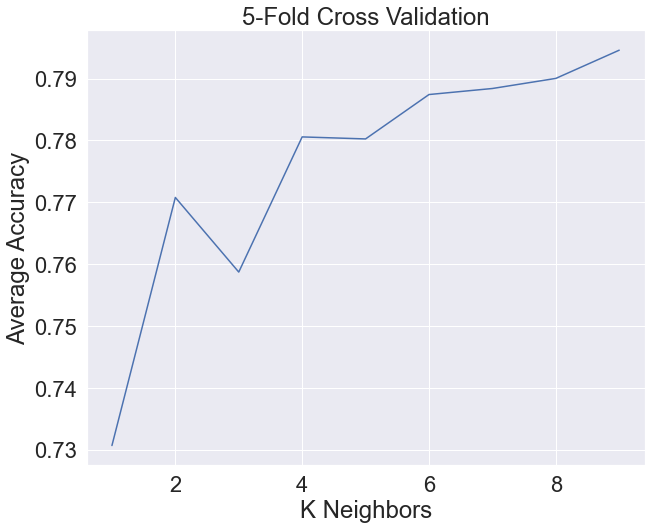

In [27]:
k_fold_result = pd.DataFrame()
k_fold_result['k'] = np.arange(1, 10)
k_fold_result['mean_test_score'] = list(knn_gscv.cv_results_['mean_test_score'])
plt.plot(k_fold_result['k'],k_fold_result['mean_test_score'])
plt.xlabel('K Neighbors')
plt.ylabel('Average Accuracy')
plt.title('5-Fold Cross Validation')
ax.set_xticklabels([])

In [28]:
# check top performing n_neighbors value 
print('Best parameters: Number of neighbors is ', knn_gscv.best_params_)

# check mean score for the top performing value of n_neighbors (mean accuracy)
print('Model accuracy (score) is:' , knn_gscv.best_score_)

Best parameters: Number of neighbors is  {'n_neighbors': 9}
Model accuracy (score) is: 0.7945815687253907


## Performance Evaluation using Test Set 

In [29]:
y_pred_proba = knn_gscv.predict_proba(X_test)[:,1]

### ROC/AUC value 

Area under the ROC curve : 0.707236


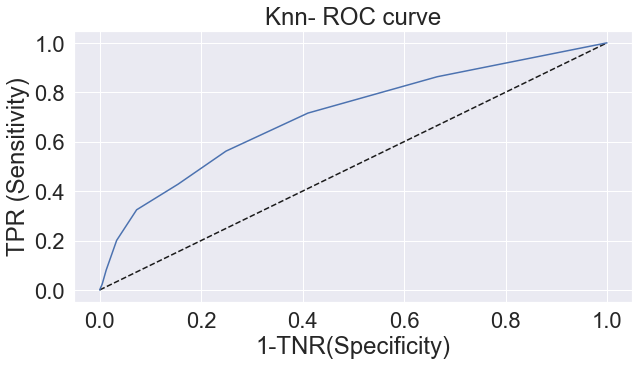

In [30]:
y_test = y_test.astype(int)
fpr, tpr, thresholds =roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('1-TNR(Specificity)')
plt.ylabel('TPR (Sensitivity)')
plt.title('Knn- ROC curve')
plt.show()

## TestSet with threshold at 0.5

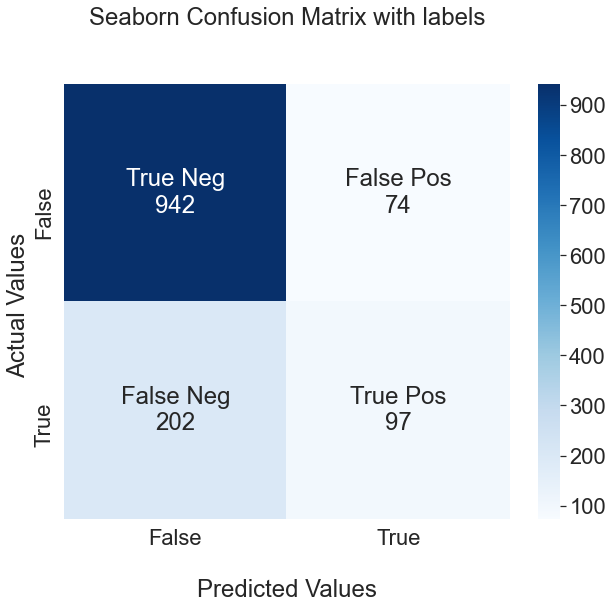

Precision: 0.57
Recall: 0.32
Accuracy: 0.79
F1-score: : 0.41


In [55]:
# We can use the Test Set to evaluate 
# the performance of the KNN model 

# calculating precision and recall while setting the cutoff 
# value to 0.5
predictions = knn_gscv.predict(X_test)
predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]

# Plot confusion matrix
cf_matrix=confusion_matrix(y_test,  predictions_nominal)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.set(rc = {'figure.figsize':(10,8)})
sns.set(font_scale = 2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()


precision = precision_score(y_test,  predictions_nominal)
recall = recall_score(y_test,  predictions_nominal)
accuracy= accuracy_score(y_test,  predictions_nominal)
F1_score= f1_score(y_test,  predictions_nominal)


print('Precision: {}'.format(round(precision,2)))
print('Recall: {}'.format(round(recall,2)))
print('Accuracy: {}'.format(round(accuracy,2)))
print('F1-score: : {}'.format(round(F1_score,2)))

From the matrix above we can see that:
- Out of the model's **positive predictions** for hospital readmission within 30 days, **57% were correctly predicted as positive.**
- Out of the **observed** positive outcomes, **32% of the outcomes were correctly predicted as positive**
- Overall, **79% of the model's predictions were correct**
- the F1-score of the model shows that on average the model's precision and recall are not very high. 

## Find the Optimal Threshold 

        fpr       tpr     1-fpr  difference  thresholds
0  0.000000  0.000000  1.000000   -1.000000    1.888889
1  0.004921  0.023411  0.995079   -0.971667    0.888889
2  0.012795  0.080268  0.987205   -0.906937    0.777778
3  0.033465  0.200669  0.966535   -0.765867    0.666667
4  0.072835  0.324415  0.927165   -0.602751    0.555556
5  0.154528  0.428094  0.845472   -0.417379    0.444444
6  0.249016  0.561873  0.750984   -0.189111    0.333333
7  0.410433  0.715719  0.589567    0.126152    0.222222
8  0.665354  0.862876  0.334646    0.528231    0.111111
9  1.000000  1.000000  0.000000    1.000000    0.000000
        fpr       tpr     1-fpr  difference  thresholds
7  0.410433  0.715719  0.589567    0.126152    0.222222


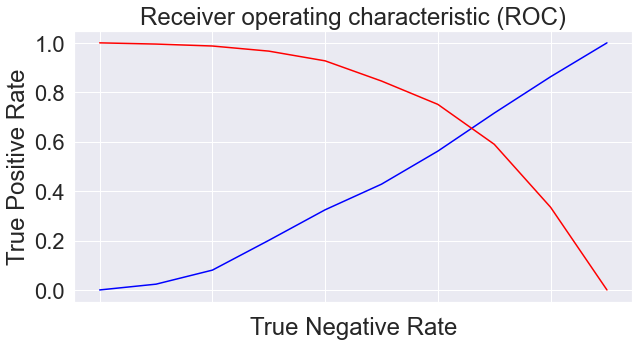

In [56]:
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),
                    'tpr' : pd.Series(tpr, index = i), 
                    '1-fpr' : pd.Series(1-fpr, index = i), 
                    'difference' : pd.Series(tpr - (1-fpr), index = i), 
                    'thresholds' : pd.Series(thresholds, index = i)})
print(roc)
##
print(roc.iloc[(roc.difference-0).abs().argsort()[:1]])

# Plot tpr vs 1-fpr
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(roc['tpr'],color='blue')
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('True Negative Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
ax.set_xticklabels([])
plt.savefig('ROC_optimal.png')


From the plot above we can see that the optimal threshold is at 0.222222

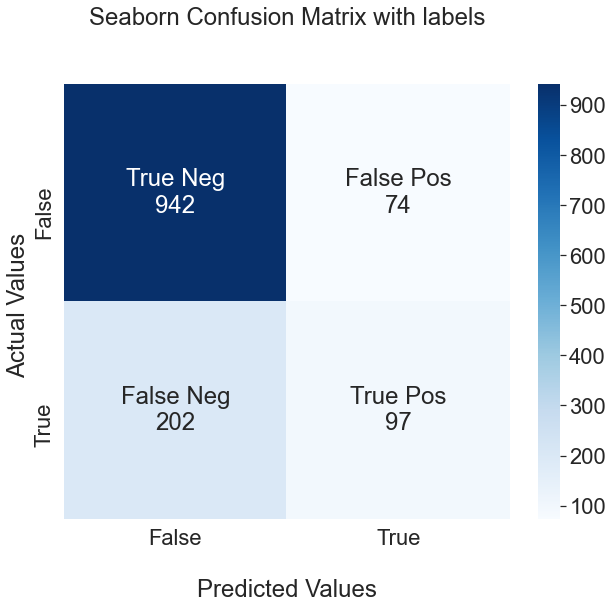

Precision: 0.57
Recall: 0.32
Accuracy: 0.79
F1-score: : 0.41


In [57]:
# We can use the Test Set to evaluate 
# the performance of the logistic model. 

# calculating precision and recall while setting the cutoff 
# value to 0.5
predictions = knn_gscv.predict(X_test)
predictions_nominal = [ 0 if x < 0.222222 else 1 for x in predictions]

# Plot confusion matrix
cf_matrix=confusion_matrix(y_test,  predictions_nominal)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.set(rc = {'figure.figsize':(10,8)})
sns.set(font_scale = 2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()


precision = precision_score(y_test,  predictions_nominal)
recall = recall_score(y_test,  predictions_nominal)
accuracy= accuracy_score(y_test,  predictions_nominal)
F1_score= f1_score(y_test,  predictions_nominal)


print('Precision: {}'.format(round(precision,2)))
print('Recall: {}'.format(round(recall,2)))
print('Accuracy: {}'.format(round(accuracy,2)))
print('F1-score: : {}'.format(round(F1_score,2)))

After changing the threshold, I noticed that there are no changes to any of the model's performance measures.

# Compare KNN and Logistic regression prediction power using ROC/AUC/F1 Score 

The follow measures are the recorded performance scores for the logisitic regression at the optimal threshold:
- **ROC/AUC:** 0.755909
- **F1-score:** 0.49

The performance measures for the KNN model are:
- **ROC/AUC:** 0.707236
- **F1-score:** 0.41

From the results above, we can see that the Logistic Regression was able to produce better results. 
- The logistic regression had a **higher area under the curve**, indicating that it was able to **distinguish between the two classes better than the KNN model**
- The logistic model also had a **higher F1-score**, which means that on average, the model had **better precision and recall** than the KNN model 

# Provide business insight from your data and models to reduce readmission rate 

Based on the logistic model:
- We know that the main drivers of hospital readmission in 30 days are the patient's **comorbidity score**, the **flu season** and the patient's **severity score**
- Since a patient's comorbidity score is one of the main drivers of hospital readmission, I recommend hospitals take **extra care examining the previous diagnosis for patients**
    - We know that patients with high comorbidity are likely to be readmitted therefore, doctors could try to **ensure that previous diagnoses of patients are also taken into consideration when prescribing a treatment**, which could help potentially lower their readmission rate 
    - For instance, doctors could try to find treatments that cover both their current diagnosis as well as their previous ones
- In addition, patients who have a high severity score, (as well as a comorbidity score) should be **carefully monitored before and after treatment.**
    - The hospital could also try to perform some analysis on **which diagnoses could lead to Acute myocardial infarction (AMI), heart failure (HF) and or Pneumonia,**
        - This could potentially help them monitor which patients may be likely to develop one of those conditions, and thus, allow the doctors to prevent or slow the onset of the conditions

- During flu seasons, hospitals could try to **let patients stay a bit longer to prevent the patients from being exposed to people with the flu**